# **FINAL PROJECT**


In [ ]:
# basic libraries
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import scipy.io as sio
from google.colab import drive
import numpy as np
import gc

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2021/FINAL_PROJECT/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2021/FINAL_PROJECT/Results/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

# **DATA LOADERS**

## **Data loader - .MAT LOADER - EXECUTE ONLY CLASS DEFINITION** 
Loads a .mat file dataset. It assumes the structure is an 'images' tag which contains a 4 dim array with the same structure as PNGFILES created --> [ image selector, width, height, RGB ]

This class is useful as mat files load way faster than reading single png files. 

In [ ]:
#Making native class loader for raw png files in a folder 
class MATDATASET(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = results_path + "realImages.mat",transform = None, maxImages = -1):
      self.transform = transform
      self.data = sio.loadmat( dataDir )['images']

      self.channels = self.data.shape[3] if len(self.data.shape) > 3 else 1 
      
      if ( maxImages > 0 ):
        self.data = self.data[:maxImages]        
     # What to do to load a single item in the dataset ( read image )    
    def __getitem__(self, index):
      data = None
      if ( self.channels > 1):
        data = self.data[index,:,:,:]
      else:
        data = self.data[index,:,:]

      data = Image.fromarray(data)
      # Apply a trasnformaiton to the image if it is indicated in the initalizer
      if self.transform is not None : 
        data = self.transform(data)
        
      # return the image and the label
      return data
      
      pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[0]



In [ ]:
def simplifyImages ( images, targetSizeImage= 32):
  data = None
  for i in range(len(images)):
    result = Image.fromarray(images[i]).convert("L")
    #result = result.resize( (targetSizeImage, targetSizeImage), resample=Image.BICUBIC )

    # insert image into own array of data
    if data is None:
      data = np.array( [ np.asarray(result) ] )
    else:
      data = np.append( data, [ np.asarray(result) ] , axis = 0 )
  return data



tr = tf.Compose([
        tf.ToTensor(), 
        #tf.Normalize(mean = [.5, .5,.5], std = [.5,.5,.5])
        ])
MATReal = MATDATASET( results_path+"realImages.mat", tr)
MATPixel = MATDATASET (results_path+"pixelArtImages.mat",tr)


sio.savemat(results_path + 'realImages_simplified_filtered.mat', {'images': simplifyImages( MATReal.data ) }) # to store data as a single mat file, opened with scipy.io.loadmat
sio.savemat(results_path + 'pixelArtImages_simplified_filtered.mat', {'images': simplifyImages( MATPixel.data ) }) # to store data as a single mat file, opened with scipy.io.loadmat



torch.Size([100, 1, 256, 256])


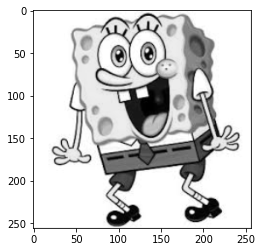

torch.Size([100, 1, 256, 256])


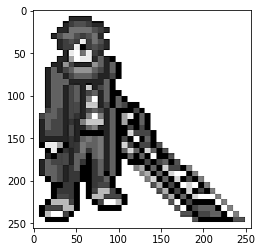

In [ ]:
tr = tf.Compose([
        tf.ToTensor(), 
        #tf.Normalize(mean = [.5, .5,.5], std = [.5,.5,.5])
        ])
MATReal = MATDATASET( results_path+"realImages_simplified_filtered.mat", tr)
MATPixel = MATDATASET (results_path+"pixelArtImages_simplified_filtered.mat",tr)

train_loader_MatReal = torch.utils.data.DataLoader(dataset=MATReal,
                                               batch_size=100, 
                                               shuffle=True)
train_loader_MatPixel = torch.utils.data.DataLoader(dataset=MATPixel,
                                               batch_size=100, 
                                               shuffle=True)

# See first image of first batch of data
images = next(iter(train_loader_MatReal))
print (images.shape)
plt.imshow(tf.ToPILImage(mode='L')(images[0]), cmap='gray')
plt.show()

# See first image of first batch of data
images = next(iter(train_loader_MatPixel))
print (images.shape)
plt.imshow(tf.ToPILImage(mode='L')(images[0]), cmap='gray')
plt.show()

# **GENERATOR**

In [ ]:
class Generator( nn.Module ):
  def __init__( self ):
    super( Generator , self).__init__()

    self.INorm16 = nn.InstanceNorm2d(16) 
    self.INorm64 = nn.InstanceNorm2d(64) 
    self.INorm128 = nn.InstanceNorm2d(128) 

    self.activation = nn.LeakyReLU(negative_slope=0.3)
    self.pooling = nn.MaxPool2d(2,2)
    self.unpooling = nn.UpsamplingNearest2d(scale_factor=2)

    self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3)

    # strided separable conv
    self.conv2_1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, groups=64)
    self.conv2_2 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0)

    # residual - separable convs treated as 1 unit
    self.conv3_1 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128)
    self.conv3_2 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)
    self.conv3_3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128)
    self.conv3_4 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)
    self.conv3_5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128)
    self.conv3_6 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)
    self.conv3_7 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128)
    self.conv3_8 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)
    self.conv3_9 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128)
    self.conv3_10 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)
    
    self.conv4_1 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128)
    self.conv4_2 = nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0)

    self.conv5_1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, groups=64)
    self.conv5_2 = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    out = self.INorm64( self.activation( self.conv1(x) ) )
    out = self.pooling(out)

    out = self.INorm64( self.activation( self.conv2_1(out) ) )
    out = self.INorm128( self.activation( self.conv2_2(out) ) )
    out = self.pooling(out)


    # residual
    out = out3_1 = self.INorm128( self.activation( self.conv3_1(out) ) )
    out = self.INorm128( self.activation( self.conv3_2(out) ) )
    
    out = self.INorm128( self.activation( self.conv3_3(out) ) )
    out = self.INorm128( self.activation( self.conv3_4(out) ) )

    out = self.INorm128( self.activation( self.conv3_5(out ) +out3_1 ) )
    out = out3_6 = self.INorm128( self.activation( self.conv3_6(out) ) )

    out = self.INorm128( self.activation( self.conv3_7(out ) ) )
    out = self.INorm128( self.activation( self.conv3_8(out) ) )

    out = self.INorm128( self.activation( self.conv3_9(out ) ) )
    out = self.INorm128( self.activation( self.conv3_10(out) ) )

    # end of residual
    out = self.INorm128( self.activation( self.conv4_1(out) ) )
    out = self.INorm64( self.activation( self.conv4_2(out +out3_6) ) )
    out = self.unpooling(out)

    out = self.INorm64( self.activation( self.conv5_1(out) ) )
    out = self.activation( self.conv5_2(out) )
    out = self.unpooling(out)

    return out

compute_model_params(Generator())

111361

# **DISCRIMINATOR**

In [ ]:
class Discriminator ( nn.Module ):
  def __init__( self ):
    super( Discriminator , self).__init__()

    self.INorm64 = nn.InstanceNorm2d(64) 
    self.INorm128 = nn.InstanceNorm2d(128) 
    self.INorm256 = nn.InstanceNorm2d(256) 

    self.activation = nn.LeakyReLU(negative_slope=0.1)
    self.sigmoid = nn.Sigmoid()


    #state =   256x256x3
    self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
    #state =   128x128x64

    # strided separable conv
    self.conv2_1 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, groups=64)
    self.conv2_2 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0)
    #state =   64x64x128

    self.conv3_1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, groups=128)
    self.conv3_2 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)
    #state =   32x32x128

    self.conv4_1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, groups=128)
    self.conv4_2 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
    #state =   16x16x256

    self.conv5_1 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, groups=256)
    self.conv5_2 = nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0)
    #state =   8x8x128

    self.fc = nn.Linear( 8*8*128, 1 )

  def forward(self, x):
    out = self.INorm64( self.activation( self.conv1(x) ) )

    out = self.INorm64( self.activation( self.conv2_1(out) ) )
    out = self.INorm128( self.activation( self.conv2_2(out) ) )

    out = self.INorm128( self.activation( self.conv3_1(out) ) )
    out = self.INorm128( self.activation( self.conv3_2(out) ) )
    
    out = self.INorm128( self.activation( self.conv4_1(out) ) )
    out = self.INorm256( self.activation( self.conv4_2(out) ) )
    
    out = self.INorm256( self.activation( self.conv5_1(out) ) )
    out = self.INorm128( self.activation( self.conv5_2(out) ) )

    out = out.view(out.size(0), -1)
    out = self.fc(out)
    out = self.sigmoid(out)
    
    return out


compute_model_params(Discriminator())

107905

# **CYCLE GAN**


In [ ]:
class GAN ( nn.Module ):
  def __init__( self ):
    super( GAN , self).__init__()

    self.Gen = Generator()
    self.Disc = Discriminator()

  def generate(self,  x ):
    return self.Gen( x )

  def discriminate(self, x ):
    return self.Disc( x )


class CycleGan ( nn.Module ):
  def __init__( self ):
    super( CycleGan , self).__init__()

    self.GanAB = GAN(); # input A, output B
    self.GanBA = GAN(); # input B, output A
    
  def disc_parameters(self ):
    return list(self.GanAB.Disc.parameters()) + list(self.GanBA.Disc.parameters())

  def gen_parameters(self):
    return list(self.GanAB.Gen.parameters()) + list(self.GanBA.Gen.parameters())
  
  def trainNN(self, train_loader_A, train_loader_B, optim_gen, optim_disc, num_epochs=10, cycle_weight=0.0001, device='cpu'):
    self.train()
    l1_loss = nn.L1Loss() # already applies mean()

    total_step = len(train_loader_A)
    update_generators = False

    for epoch in range(num_epochs):

      gen_loss_avg = 0
      disc_loss_avg = 0
      nBatches = 0

      iteratorA = iter(train_loader_A)
      iteratorB = iter(train_loader_B)

      #update_generators = True if ( epoch % 2 == 0 ) else False #alternate batches
      update_generators = not update_generators

      for i in range(len(train_loader_A)):
        A = next(iteratorA)
        A = A.to( device )
        B = next(iteratorB) 
        B = B.to( device )

        AB_generations = self.GanAB.generate(A)
        BA_generations = self.GanBA.generate(B)
        
        AB_reconstruction = self.GanBA.generate( AB_generations ) # reconstruct A samples
        BA_reconstruction = self.GanAB.generate( BA_generations ) # reconstruct B samples

        probAB_fake = torch.clamp( self.GanAB.discriminate( AB_generations ), min=0.00001, max= 0.99999) # generated images
        probAB_real = torch.clamp( self.GanAB.discriminate( B ) , min=0.00001, max= 0.99999)# real images

        probBA_fake = torch.clamp( self.GanBA.discriminate( BA_generations ), min=0.00001, max= 0.99999) # generated images
        probBA_real = torch.clamp( self.GanBA.discriminate( A ), min=0.00001, max= 0.99999) # real images

        # disc loss
        discAB_loss = -0.5*(torch.log(probAB_real) + torch.log(1-probAB_fake)).mean()
        discBA_loss = -0.5*(torch.log(probBA_real) + torch.log(1-probBA_fake)).mean()

        disc_loss = discAB_loss + discBA_loss
        # gen loss
        genAB_loss = -1 * torch.log(probAB_fake).mean()
        genBA_loss = -1 * torch.log(probBA_fake).mean()

        cycle_loss = (torch.pow(AB_reconstruction - A, 2)).sum() / len(A) + (torch.pow(BA_reconstruction - B,2)).sum()/ len(B) #L2 loss
        #cycle_loss = (torch.abs(AB_reconstruction - A)).sum() / len(A) + (torch.abs(BA_reconstruction - B)).sum()/ len(B) # L1 loss
        gen_loss =  cycle_weight * cycle_loss + genAB_loss + genBA_loss 
        
        if update_generators:
          optim_gen.zero_grad()
          gen_loss.backward()
          optim_gen.step()
        else:
          optim_disc.zero_grad()
          disc_loss.backward()
          optim_disc.step()         

        
        
        gen_loss_avg += gen_loss.cpu().item()
        disc_loss_avg += disc_loss.cpu().item()

        nBatches+=1

        if (i)% 75 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f} ( cycle: {:.4f}, gen-disc:{:.4f}), Disc Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, gen_loss.cpu().item(), cycle_loss.cpu().item(), (genAB_loss.cpu().item() + genBA_loss.cpu().item()), disc_loss.cpu().item()))
        #gc.collect()
        #torch.cuda.empty_cache()

      print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}' 
                      .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches))
  
  def evalNN ( self, data_loader, mode='AB' ): # mode = from A to B, or from B to A, RecA reconstruction of A, RecB reconstruction of B
    self.eval()

    with torch.no_grad():
      imgs = next(iter(data_loader))
      imgs = imgs.to(device)
      # get network predictions
      result = None
      if mode == 'AB':
        result = self.GanAB.Gen( imgs )
      elif mode== 'BA' :
        result = self.GanBA.Gen( imgs )
      elif mode == 'RecA':
        result = self.GanBA.Gen( self.GanAB.Gen( imgs ) )
      elif mode == 'RecB':
        result = self.GanAB.Gen( self.GanBA.Gen( imgs ) )

      
      for i in range(len(result)):
        plt.subplot(1,2,1)
        r = torch.clamp(result[i], min=0.0001, max=0.9999)
        plt.imshow(tf.ToPILImage(mode='L')( r ), cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(tf.ToPILImage(mode='L')( imgs[i] ), cmap='gray')
        plt.show()
    
    
compute_model_params(CycleGan())

463620

# **TRAINING**

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
#device = torch.device('cpu')
cycleGAN = CycleGan()
cycleGAN.to(device)

CycleGan(
  (GanAB): GAN(
    (Gen): Generator(
      (INorm16): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (INorm64): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (INorm128): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.3)
      (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (unpooling): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (conv2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
      (conv2_2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (conv3_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (conv3_2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (conv3_3): Conv2d

In [ ]:

tr = tf.Compose([
        tf.ToTensor(), 
        #tf.Normalize(mean = [.5, .5,.5], std = [.5,.5,.5])
        ])
MATReal = MATDATASET( results_path+"realImages_simplified_filtered.mat", tr)
MATPixel = MATDATASET (results_path+"pixelArtImages_simplified_filtered.mat",tr)

train_loader_MatReal = torch.utils.data.DataLoader(dataset=MATReal,
                                               batch_size=7, 
                                               shuffle=True)
train_loader_MatPixel = torch.utils.data.DataLoader(dataset=MATPixel,
                                               batch_size=7, 
                                               shuffle=True)

In [ ]:
num_epochs = 20

lrD = 0.0005
lrG = 0.0025
cycle_weight = 0.0001

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(cycleGAN.disc_parameters(), lr=lrD, weight_decay=0.0001)
optimizerG = torch.optim.Adam(cycleGAN.gen_parameters(), lr=lrG, weight_decay=0.0001)

cycleGAN.trainNN(train_loader_MatReal, train_loader_MatPixel, optimizerG, optimizerD, num_epochs=num_epochs, cycle_weight=cycle_weight, device=device)

Epoch [1/20], Step [1/119], Gen. Loss: 10.9261 ( cycle: 96127.3984, gen-disc:1.3133), Disc Loss: 1.4938
Epoch [1/20], Step [76/119], Gen. Loss: 3.9967 ( cycle: 37819.6602, gen-disc:0.2147), Disc Loss: 3.2147
Epoch [1/20], Step [119/119], Gen. Loss: 4.4559, Disc Loss: 2.5780
Epoch [2/20], Step [1/119], Gen. Loss: 2.8892 ( cycle: 27877.9258, gen-disc:0.1014), Disc Loss: 3.7088
Epoch [2/20], Step [76/119], Gen. Loss: 22.3646 ( cycle: 27272.7617, gen-disc:19.6373), Disc Loss: 0.0013
Epoch [2/20], Step [119/119], Gen. Loss: 19.9587, Disc Loss: 0.0890
Epoch [3/20], Step [1/119], Gen. Loss: 23.0372 ( cycle: 24267.6348, gen-disc:20.6104), Disc Loss: 0.0005
Epoch [3/20], Step [76/119], Gen. Loss: 1.6648 ( cycle: 16601.5742, gen-disc:0.0046), Disc Loss: 7.1210
Epoch [3/20], Step [119/119], Gen. Loss: 2.2808, Disc Loss: 6.1702
Epoch [4/20], Step [1/119], Gen. Loss: 1.0220 ( cycle: 10205.2754, gen-disc:0.0014), Disc Loss: 7.5342
Epoch [4/20], Step [76/119], Gen. Loss: 19.4210 ( cycle: 10737.2314, 

# **TESTING**

 A -> B 


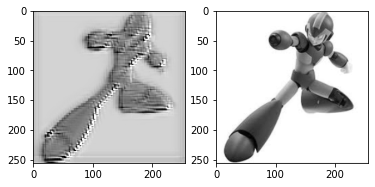

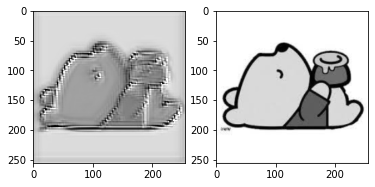

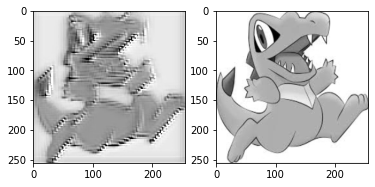

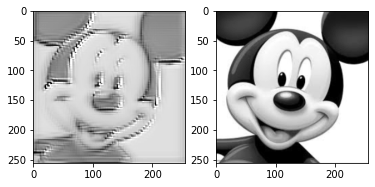

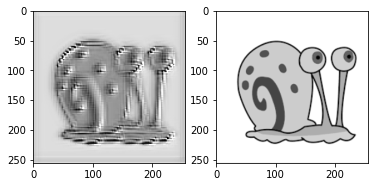

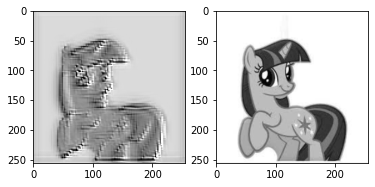

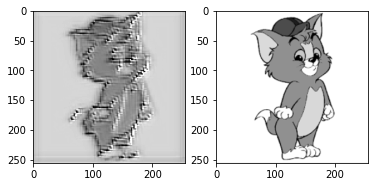

--------------------------------------------------------
 Reconstruction of A 


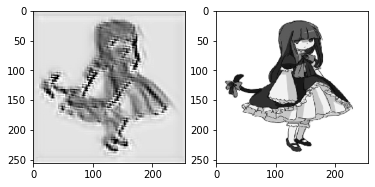

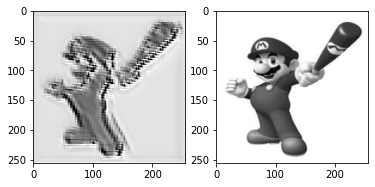

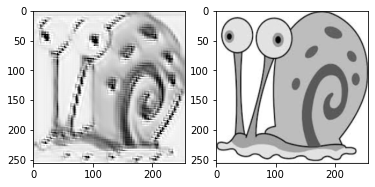

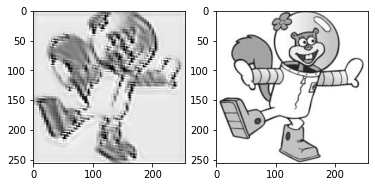

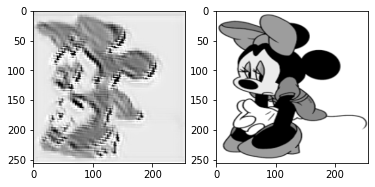

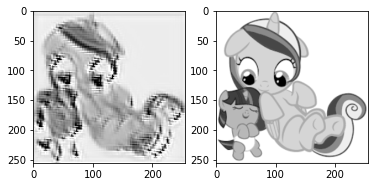

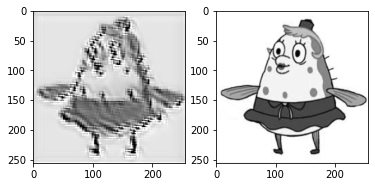

--------------------------------------------------------
 B -> A 


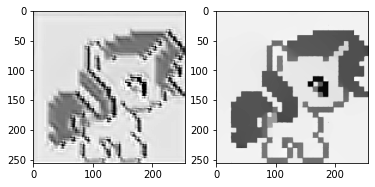

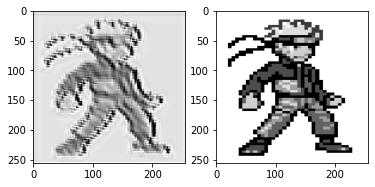

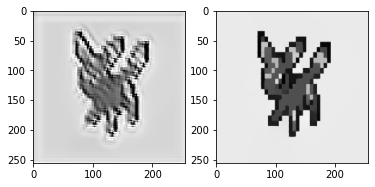

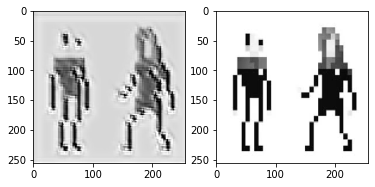

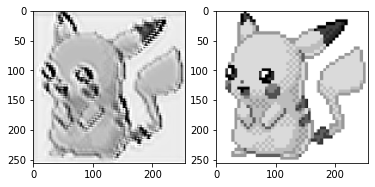

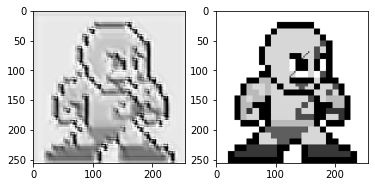

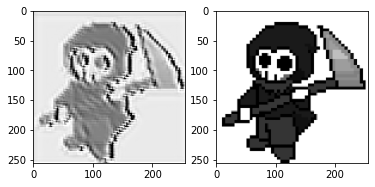

--------------------------------------------------------
 Reconstruction B 


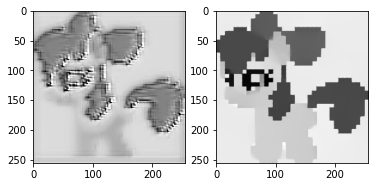

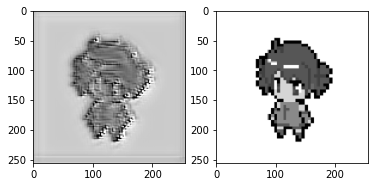

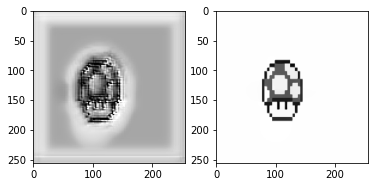

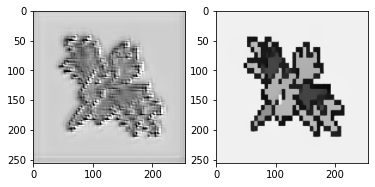

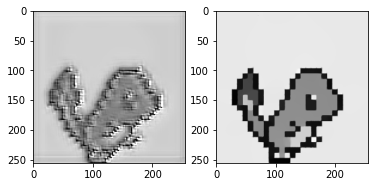

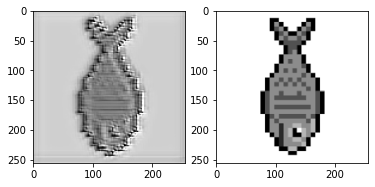

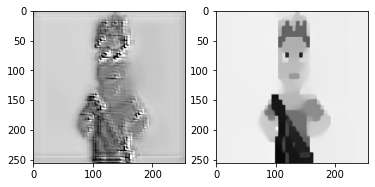

--------------------------------------------------------


In [ ]:

# pixelate real images
print(" A -> B ")
cycleGAN.evalNN( train_loader_MatReal, 'AB')
print("--------------------------------------------------------")


# see how well reconstructs
print(" Reconstruction of A ")
cycleGAN.evalNN( train_loader_MatReal, 'RecA')
print("--------------------------------------------------------")

# convert pixelated dataset to real images
print(" B -> A ")
cycleGAN.evalNN( train_loader_MatPixel, 'BA')
print("--------------------------------------------------------")

# see how well reconstructs pixelated images
print(" Reconstruction B ")
cycleGAN.evalNN( train_loader_MatPixel, 'RecB')
print("--------------------------------------------------------")